# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

**Student :** Théo Di Piazza (theo.dipiazza@gmail.com)

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

<u>**Question 1 - Answer**</u>

I use the Pytorch library to load the CIFAR-10 dataset. Then I select the first 100 samples of the CIFAR10 train set with the **Subset** function.

In [33]:
# Libraries
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [67]:
#@title load CIFAR10 train and test set

# batch
batch_size = 10

## STEP 1 : LOAD CIFAR10 100 FIRST SAMPLES AND COMPUTE MEAN ACCURACY OF DATA
# load entire train set
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
# subset first 100 samples
trainset = torch.utils.data.Subset(trainset_full, list(range(100)))
# compute mean, std of first 100 samples to normalize
data = trainset.dataset.data / 255 
mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
print(f'100 first samples : RGB data - Mean : {mean} - Standart-Deviation : {std} !')

## STEP 2 : RELOAD CIFAR100 100 FIRST SAMPLES WITH ADJUSTED NORMALIZATION MEAN AND ACCURACY
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tuple(mean), tuple(std))])
# reload CIFAR10 with adjusted normalization values
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# reload subset first 100 samples
trainset = torch.utils.data.Subset(trainset_full, list(range(100)))
# load dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

## STEP 4 : LOAD CIFAR10 UNLABEL SET
idx_cifar, idx_train = list(range(100)), list(range(50000)) # idx of train, idx of all samples
idx_unlabel = list(set(idx_cifar) - set(idx_train)) # indexes of unlabel data
unlabeldataset = torch.utils.data.Subset(trainset_full, idx_unlabel)
unlabelloader = torch.utils.data.DataLoader(unlabeldataset, batch_size=batch_size, shuffle=False)

## STEP 4 : LOAD CIFAR10 TEST SET
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

print(f'> Successfully loaded train dataset/dataloader with {len(trainset)} samples!')
print(f'> Successfully loaded test dataset/dataloader with {len(testset)} samples!')

Files already downloaded and verified
100 first samples : RGB data - Mean : [0.49139968 0.48215841 0.44653091] - Standart-Deviation : [0.24703223 0.24348513 0.26158784] !
Files already downloaded and verified
Files already downloaded and verified
> Successfully loaded train dataset/dataloader with 100 samples!
> Successfully loaded test dataset/dataloader with 10000 samples!


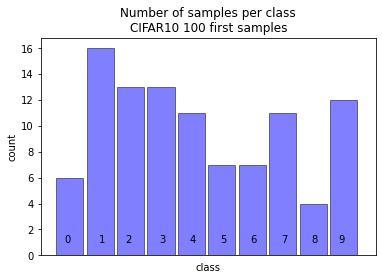

In [123]:
# display number of samples for each class
trainset_labels = []
for _, y in trainloader:
  trainset_labels += y.detach().cpu().tolist()

# plot
plt.hist(trainset_labels, 10, facecolor='blue', alpha=0.5, edgecolor = "black", align='left', width=0.8)
plt.title('Number of samples per class\nCIFAR10 100 first samples')
plt.xticks([])
for i, xname in enumerate([-0.2, 0.8, 1.6, 2.6, 3.5, 4.4, 5.3, 6.2, 7.1, 7.9]):
  plt.text(xname, 1, i)
plt.xlabel('class'); plt.ylabel('count');
plt.show()

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

<u>**Question 2 - Answer**</u>

The evaluation of the training procedure is difficult because the train set is much smaller than the test set (100 samples VS 10000 samples). Since the quality of the training depends on the quality of the data, it is difficult to know whether 100 training samples are representative enough of the distribution of the total train set to present good results. There is a risk that the model will overfit on the few train set data. Some classes may be under-represented.

Here are some solutions to this problem:     

- **Data Augmentation:** which consists of increasing the size of the dataset via deformations, modifications of colour intensities, rotation, translation, cropping, etc.

- **Transfer learning:** which consists of fine-tuning a pre-trained model on our small train set to benefit from pre-trained weights.

- **Ensembe methods:** which consists of training several models on the dataset and exploiting/combining the results of the models and improving performance. Even with this, it is not guaranteed that the problem will be completely solved.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

<u>**Question 3- Strategy**</u>

As recommended by the topic, I use the code available at https://github.com/kuangliu/pytorch-cifar to implement the ResNet18.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

To begin with, we implement the ResNet model

In [36]:
#@title ResNet model

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

Once the architecture is defined, the objective is to train the model on $X_{train}$ and to test it on $X_{test}$.

Below are defined some useful functions to train, test the model.

In [37]:
#@title utils function
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss_return, train_acc_return = train_loss/(batch_idx+1), 100.*correct/total
    print(f'> TRAIN SET : Loss: {train_loss_return:.3f} | Acc: {train_acc_return:.2f}% !')
    return train_loss_return, train_acc_return

# Test
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        test_loss_return, test_acc_return = test_loss/(batch_idx+1), 100.*correct/total
        print(f'> TEST SET : Loss: {test_loss_return:.3f} | Acc: {test_acc_return}% !')
    
    return test_loss_return, test_acc_return

In [ ]:
#@title set up model, optimizer, loss, scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initialize the model
net = ResNet18()
net = net.to(device)

# criterion, optimizer
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
#@title iterate for training
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss_epoch, train_acc_epoch = train(epoch)
    test_loss_epoch, test_acc_epoch = test(epoch)

    train_losses.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    test_losses.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    scheduler.step()


Epoch: 0
> TRAIN SET : Loss: 2.663 | Acc: 10.00% !
> TEST SET : Loss: 2.356 | Acc: 10.14% !

Epoch: 1
> TRAIN SET : Loss: 2.440 | Acc: 21.00% !
> TEST SET : Loss: 2.887 | Acc: 12.61% !

Epoch: 2
> TRAIN SET : Loss: 2.318 | Acc: 23.00% !
> TEST SET : Loss: 3.513 | Acc: 16.65% !

Epoch: 3
> TRAIN SET : Loss: 1.770 | Acc: 44.00% !
> TEST SET : Loss: 3.210 | Acc: 15.8% !

Epoch: 4
> TRAIN SET : Loss: 1.050 | Acc: 60.00% !
> TEST SET : Loss: 3.305 | Acc: 19.16% !

Epoch: 5
> TRAIN SET : Loss: 0.799 | Acc: 77.00% !
> TEST SET : Loss: 3.414 | Acc: 19.71% !

Epoch: 6
> TRAIN SET : Loss: 0.545 | Acc: 87.00% !
> TEST SET : Loss: 3.318 | Acc: 21.01% !

Epoch: 7
> TRAIN SET : Loss: 0.517 | Acc: 80.00% !
> TEST SET : Loss: 4.186 | Acc: 21.09% !

Epoch: 8
> TRAIN SET : Loss: 0.456 | Acc: 84.00% !
> TEST SET : Loss: 4.291 | Acc: 21.71% !

Epoch: 9
> TRAIN SET : Loss: 0.419 | Acc: 85.00% !
> TEST SET : Loss: 3.991 | Acc: 16.86% !


> Best accuracy for train set : 87.0 !
> Best accuracy for test set : 21.71 !



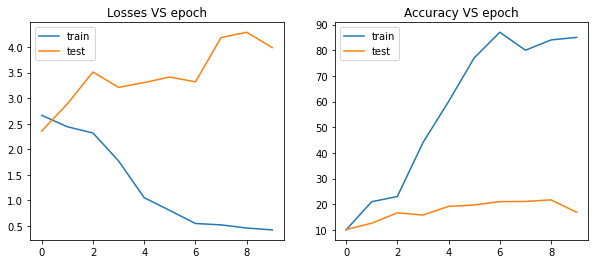

In [ ]:
#@title Display interesting results
import matplotlib.pyplot as plt
import numpy as np

# train, test accuracy
print(f'> Best accuracy for train set : {np.max(train_acc)} !')
print(f'> Best accuracy for test set : {np.max(test_acc)} !\n')

# display losses, accuracies VS epochs
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(train_losses, label='train')
axes[0].plot(test_losses, label='test')
axes[0].set_title('Losses VS epoch')
axes[0].legend()

axes[1].plot(train_acc, label='train')
axes[1].plot(test_acc, label='test')
axes[1].set_title('Accuracy VS epoch')
axes[1].legend()

<u>**Question 3 - Results**</u>

Here are the results with my implementation :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 from scratch  | 10 | 87.0 | 21.71 |

The Accuracy on Full Data is **93.02**% ! 

> Source of Resnet paper : https://arxiv.org/abs/1512.03385

> Source of github implementation : https://github.com/kuangliu/pytorch-cifar

It can be seen that the accuracy obtained from the train set of 100 samples and the ResNet-18 trained from scratch is much lower than that obtained with the whole train set (21.71% vs 93.02%), which is consistent with the difference in size of the train sets used.

This corresponds to the expected results, as mentioned by the subject, and shows an overfitting phenomenon on the training dataset.

Concernant les temps d'exécutions, les 10 epochs sont executés en XXmin.

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

<u>**Question 4 - Strategy**</u>

Following on from question 1, I have chosen to use a ResNet pretrain and add 2 layers : a linear layer with a ReLU as activation function followed by a linear layer for classification. The parameters of the backbone are frozen, the parameters of linear layers are not.

I tried with 2 backbones : ResNet18, ResNet34. ResNet34 has a more complex architecture than ResNet18, so the results are expected to be more satisfactory with ResNet34. However, care should be taken as this is not always the case, depending on the data and training conditions.

About the data, as ResNet are pretrained on ImageNet, I re-loaded CIFAR10 datasets and performed same transformation (normalization, reshape) as ImageNet dataset to fully benefit from the backbones.

The first step is to implement the ResNetTransfer model, which takes a pretrained resnet as a backbone and adds linear output layers for classification.

In [38]:
#@title Model ResNetTransfert
from torchvision.models import resnet18, resnet34

class ResNetTransfert(nn.Module):
  """
  Model which uses ResNet followed by linear layers
  """
  def __init__(self, version=18, backbone_freeze=True):
    '''
    Initializes the model
    Input:
      version(str): version of the Resnet (50, 152...)
    '''
    super(ResNetTransfert, self).__init__()

    # load pretrained resnet
    if(version==18):
      resnet = resnet18(pretrained=True)
    elif(version==34):
      resnet = resnet34(pretrained=True)
  
    # remove last layers
    wanted_layers = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*wanted_layers)
    # freeze backbone parameters if needed
    if(backbone_freeze):
      for param in self.resnet.parameters():
        param.requires_grad = False
    
    # linear layer for classification
    self.linear1 = nn.Linear(resnet.fc.in_features, 100)
    self.linear2 = nn.Linear(100, 10)
    
  def forward(self, x):
    '''
    Forward propagation of the Net for a given x.
    '''
    # First step : Resnet
    output = self.resnet(x)
    output = output.view(output.size(0), -1)

    output = F.relu(self.linear1(output))
    output = self.linear2(output)

    return output

In [16]:
#@title load CIFAR10 data with same context of ResNet18 pretraining on ImageNet

# transform compose for ResNet
mean_ImageNet, std_ImageNet, shape_ImageNet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
transform_ImageNet = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize(mean=mean_ImageNet, std=std_ImageNet),
                                        transforms.Resize(shape_ImageNet)])

## LOAD TRAIN
# load entire train set
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ImageNet)
# subset first 100 samples
trainset = torch.utils.data.Subset(trainset_full, list(range(100)))

# load dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

## LOAD TEST
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ImageNet)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
#@title set up model, optimizer, loss, scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initialize the model
net = ResNetTransfert(version=18)
net = net.to(device)

# criterion, optimizer
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.7)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [22]:
#@title iterate for training
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss_epoch, train_acc_epoch = train(epoch)
    test_loss_epoch, test_acc_epoch = test(epoch)

    train_losses.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    test_losses.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    scheduler.step()


Epoch: 0
> TRAIN SET : Loss: 2.307 | Acc: 11.00% !
> TEST SET : Loss: 2.297 | Acc: 14.71% !

Epoch: 1
> TRAIN SET : Loss: 2.140 | Acc: 28.00% !
> TEST SET : Loss: 2.226 | Acc: 16.17% !

Epoch: 2
> TRAIN SET : Loss: 1.974 | Acc: 31.00% !
> TEST SET : Loss: 2.153 | Acc: 25.87% !

Epoch: 3
> TRAIN SET : Loss: 1.829 | Acc: 43.00% !
> TEST SET : Loss: 2.038 | Acc: 21.64% !

Epoch: 4
> TRAIN SET : Loss: 1.614 | Acc: 53.00% !
> TEST SET : Loss: 1.847 | Acc: 35.36% !

Epoch: 5
> TRAIN SET : Loss: 1.417 | Acc: 61.00% !
> TEST SET : Loss: 1.730 | Acc: 40.0% !

Epoch: 6
> TRAIN SET : Loss: 1.181 | Acc: 64.00% !
> TEST SET : Loss: 1.685 | Acc: 39.65% !

Epoch: 7
> TRAIN SET : Loss: 1.229 | Acc: 63.00% !
> TEST SET : Loss: 1.564 | Acc: 44.78% !

Epoch: 8
> TRAIN SET : Loss: 0.912 | Acc: 80.00% !
> TEST SET : Loss: 1.477 | Acc: 47.29% !

Epoch: 9
> TRAIN SET : Loss: 0.799 | Acc: 85.00% !
> TEST SET : Loss: 1.470 | Acc: 46.09% !


> Best accuracy for train set : 85.0 !
> Best accuracy for test set : 47.29 !



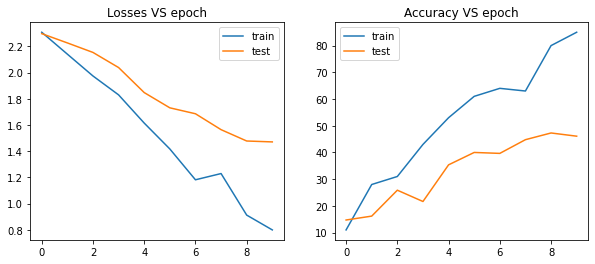

In [23]:
#@title Display interesting results
import matplotlib.pyplot as plt

# train, test accuracy
print(f'> Best accuracy for train set : {np.max(train_acc)} !')
print(f'> Best accuracy for test set : {np.max(test_acc)} !\n')

# display losses, accuracies VS epochs
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(train_losses, label='train')
axes[0].plot(test_losses, label='test')
axes[0].set_title('Losses VS epoch')
axes[0].legend()

axes[1].plot(train_acc, label='train')
axes[1].plot(test_acc, label='test')
axes[1].set_title('Accuracy VS epoch')
axes[1].legend()

<u>**Question 4 - Results**</u>

Here are the results with my implementation :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 TransfertLearning  | 10 | 85.0 | 47.29 |
|   ResNet34 TransfertLearning  | 10 | 82.0 | 50.81 |

Thanks to Transfer Learning, we obtain an accuracy of +30.14% with ResNet18 and +33.96% with ResNet34 compared to the previous result. This result is consistent because we benefit from the pre-trained weights on the ImageNet dataset. 

In terms of computation time, ResNet34 is longer than ResNet18 because there are more parameters.

A way to improve these results would be to not freeze the ResNet parameters. Indeed it could be interesting to make parameters of the backbone learnable and to use a lower learning rate for the backbone than for the linear layer, to benefit from the pretraining step.

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

<u>**Question 5 - Answer**</u>

**For translation,** some pixels of the image may disappear from the frame and pixels without information appear. This is a problem because very important elements of the image may disappear.

**For rotation,** the problem is similar: pixels close to the corners of the original image may disappear from the image. If this is not done properly, distortions can appear, and the information carried by the image is deteriorated. **To address this problem,** a solution may be to use interpolation to reconstruct the missing pixels.

**For scaling,** if the change in scale is too abrupt, image quality can be lost, especially for small images. Also, some important elements may disappear if the scaling is done on a small part of the image. **To address this problem,** one solution may be to not apply too much scaling, in order to retain as much information as possible from the initial image. Up-sampling can also be used, if it results in an image of sufficient quality.

**For colour changes,** if the changes in pixel intensities are too rough: it can be difficult even for the naked eye to recognise an image because the resulting intensities are too strong, or too weak. In addition, if this is not done properly, some shapes may disappear because objects could be confused after colour modification. **To address this problem,** one solution is to apply normalization, and to choose colour changes and insensitivities adapted to the dataset by looking, parameter by parameter, at the influence of the transformation.

The changes can be very significant, especially for such small images (32x32). Up-sampling before pre-processing to increase the size may be an avenue to explore if the quality obtained remains satisfactory.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

<u>**Question 6 - Strategy**</u>

The objective is to apply transformations to the images in the train set, in order to have more images. For this, the transformations retained will be the following: rotation, flip, modification of colours/intensities/Grayscale, addition of blur, crop. 

These transformations will be carried out using the **PyTorch** library. 

I was inspired by the transformations from the paper (Bardes et al, 2022, https://arxiv.org/abs/2105.04906, https://github.com/facebookresearch/vicreg)

2 modèles seront comparés. 

**1 - Data Augmentation for model without pretraining :** I will first evaluate the impact of data augmentation on a ResNet18 model trained from scratch.

**2 - Data Augmentation for model with pretraining :** The impact of data augmentation on a model using a pre-trained ResNet18 backbone will then be evaluated.

## Data Augmentation for model without pretraining

In a first step, I try a data augmentation method with a model that uses a ResNet18 backbone without pretraining.

In [ ]:
#@title transform compose
# define transform for train and test
transform_train = transforms.Compose([
                 transforms.RandomHorizontalFlip(),
                 # transforms.RandomCrop(size=[32,32], padding=3),
                 transforms.GaussianBlur(kernel_size=(3,3)),
                 transforms.ColorJitter(hue=.1),
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

transform_test = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

In [ ]:
#@title load data

## TRAIN
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
# reload subset first 100 samples
trainset = torch.utils.data.Subset(trainset_full, list(range(100)))
# load dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

## TEST
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#@title initialize the model, optimizer
net = ResNet18()
net = net.to(device)

# criterion, optimizer
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
#@title iterate for training
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(0, 10):
    train_loss_epoch, train_acc_epoch = train(epoch)
    test_loss_epoch, test_acc_epoch = test(epoch)

    train_losses.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    test_losses.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    scheduler.step()


Epoch: 0
> TRAIN SET : Loss: 2.764 | Acc: 14.00% !
> TEST SET : Loss: 2.349 | Acc: 9.97% !

Epoch: 1
> TRAIN SET : Loss: 3.027 | Acc: 13.00% !
> TEST SET : Loss: 3.974 | Acc: 11.25% !

Epoch: 2
> TRAIN SET : Loss: 2.641 | Acc: 20.00% !
> TEST SET : Loss: 7.860 | Acc: 14.18% !

Epoch: 3
> TRAIN SET : Loss: 2.457 | Acc: 19.00% !
> TEST SET : Loss: 4.871 | Acc: 17.81% !

Epoch: 4
> TRAIN SET : Loss: 2.215 | Acc: 22.00% !
> TEST SET : Loss: 6.013 | Acc: 18.08% !

Epoch: 5
> TRAIN SET : Loss: 2.343 | Acc: 24.00% !
> TEST SET : Loss: 3.574 | Acc: 17.56% !

Epoch: 6
> TRAIN SET : Loss: 1.883 | Acc: 42.00% !
> TEST SET : Loss: 2.851 | Acc: 21.21% !

Epoch: 7
> TRAIN SET : Loss: 1.801 | Acc: 37.00% !
> TEST SET : Loss: 2.805 | Acc: 23.69% !

Epoch: 8
> TRAIN SET : Loss: 1.853 | Acc: 33.00% !
> TEST SET : Loss: 2.916 | Acc: 20.56% !

Epoch: 9
> TRAIN SET : Loss: 1.564 | Acc: 48.00% !
> TEST SET : Loss: 2.856 | Acc: 23.52% !


In [ ]:
print(f'> Best accuracy for train set : {np.max(train_acc)} !')
print(f'> Best accuracy for test set : {np.max(test_acc)} !\n')

> Best accuracy for train set : 48.0 !
> Best accuracy for test set : 23.69 !



From now on, we will study the impact of data augmentation on 2 pretrained models: ResNet18 and ResNet34. If you want to run the code again, please make sure that you choose the desired backbone (RN18 or RN34) at model initialization.

## Data Augmentation for model with pretraining 

In [25]:
#@title transform compose
from torchvision.transforms import InterpolationMode
mean_ImageNet, std_ImageNet, shape_ImageNet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=3),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomApply([transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.1)], p=0.4),
        transforms.ColorJitter(hue=.05),
        #transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=(3, 3)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_ImageNet, std=std_ImageNet),
        transforms.Resize(shape_ImageNet)])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(mean=mean_ImageNet, std=std_ImageNet),
                                      transforms.Resize(shape_ImageNet)])

In [26]:
# load data
## TRAIN
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset = torch.utils.data.Subset(trainset_full, list(range(100)))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

## TEST
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
#@title set up model, optimizer, loss, scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initialize the model
net = ResNetTransfert(version=34)
net = net.to(device)

# criterion, optimizer
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.7)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [32]:
#@title iterate for training
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(0, 20):
    train_loss_epoch, train_acc_epoch = train(epoch)
    test_loss_epoch, test_acc_epoch = test(epoch)

    train_losses.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    test_losses.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    scheduler.step()


Epoch: 0
> TRAIN SET : Loss: 2.302 | Acc: 13.00% !
> TEST SET : Loss: 2.256 | Acc: 21.25% !

Epoch: 1
> TRAIN SET : Loss: 2.126 | Acc: 25.00% !
> TEST SET : Loss: 2.160 | Acc: 27.63% !

Epoch: 2
> TRAIN SET : Loss: 2.040 | Acc: 27.00% !
> TEST SET : Loss: 2.069 | Acc: 30.83% !

Epoch: 3
> TRAIN SET : Loss: 1.956 | Acc: 31.00% !
> TEST SET : Loss: 2.048 | Acc: 27.16% !

Epoch: 4
> TRAIN SET : Loss: 1.813 | Acc: 42.00% !
> TEST SET : Loss: 1.923 | Acc: 35.03% !

Epoch: 5
> TRAIN SET : Loss: 1.657 | Acc: 43.00% !
> TEST SET : Loss: 1.887 | Acc: 31.28% !

Epoch: 6
> TRAIN SET : Loss: 1.522 | Acc: 47.00% !
> TEST SET : Loss: 1.721 | Acc: 40.25% !

Epoch: 7
> TRAIN SET : Loss: 1.414 | Acc: 61.00% !
> TEST SET : Loss: 1.698 | Acc: 42.47% !

Epoch: 8
> TRAIN SET : Loss: 1.245 | Acc: 60.00% !
> TEST SET : Loss: 1.666 | Acc: 37.94% !

Epoch: 9
> TRAIN SET : Loss: 1.187 | Acc: 63.00% !
> TEST SET : Loss: 1.558 | Acc: 43.35% !

Epoch: 10
> TRAIN SET : Loss: 1.132 | Acc: 66.00% !
> TEST SET : Loss

<u>**Question 6 - Results**</u>

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 from scratch + DataAug | 10 | 48.0 | 23.69 |
|   ResNet18 TransfertLearning + DataAug | 20 | 70.0 | 52.71 |
|   ResNet34 TransfertLearning + DataAug | 20 | 84.0 | 54.38 |

**Observations for the model without pretraining** : We see an improvement in accuracy on the test set of +1.98% compared to the baseline results, without data augmentation (23.69% vs 21.71% on 10 epochs). This performance improvement is not huge, but it shows that data augmentation has a positive impact on the performance of the model in this case.

**Observations for the model with pretraining** : The best results on the test set obtained are 52.71% with pretrained ResNet18 and 54.38% pretrained ResNet34. Compared to the previous results, we observe better results than without data augmentation. However, it is important to note that the model had to be trained on 20 epochs instead of 10, in order to perform better than without data augmentation: this increases the training time. Furthermore, to obtain these results I had to play with the different data augmentation parameters of the following transformations: ColorJitter, GaussianBlur & RandomCrop. Indeed, when the data increases are too abrupt, the model performs much worse than without data augmentation. I had to vary parameters (such as hue, scale to crop, contrast, saturation) one by one, and use "softer" transformations to get better results than before.

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

**Answer Question 7** : 

- **Baseline** : Le premier modèle implémenté est un ResNet. L'avantage de ce modèle, caractérisé par la présence de connexions résiduelles, qui sont des connexions des couches associées à différents niveaux de profondeurs, est qu'il présente de solides performances pour différentes tâches de vision et permet d'éviter le problème du vanishing gradient. Toutefois, ce modèle est constitué d'un nombre très importants de paramètres (par exemple ResNet18 a environ 11 millions de paramètres), ce qui rend son entrainement très long. La meilleur accuracy obtenue est de 21.71%.

- **Transfert Learning** : One advantage of using this method is that it allows the parameters of a pre-trained model to be used. For ResNet, the backbones were pre-trained on the ImageNet dataset. It is then assumed that the model has already learned to extract relevant visual information in memory, which allows it to be used for fine-tuning on a different task to obtain better results. The best accuracy obtained is 47.29% for ResNet18 and 50.81% for ResNet34.

- **Data Augmentation** : The advantage of this method is that it increases the size of the training dataset by adding transformed images to the original dataset. This allows the model to see a larger panel of images during training, in order to improve its performance and make it more general. For this tutorial, the relevant transformations were: flip, crop, intensity modification and normalisation. It is important to note that I had to take the time to vary the parameters of each type of transformation, because when they are badly chosen, the performance of the model is not improved, or even worse than without data augmentation. Regarding the negative points of this method, one must be very careful with the choice of transforms, as this can lead to images without interesting information and reduce the performance of the model. In addition, it increases the training time. The best accuracy obtained is 52.71% for ResNet18 and 54.38% for ResNet34.

- **Weak Supervision** : Finally, the Curriculum Labeling method was used to try to increase the performance of the model by using unlabelled data. An advantage of this method is the fact that it can use unlabelled data, potentially training the model on a larger dataset. In addition, the method used is intuitively easy to understand and implement. However, the training times become very long with the number of iterations. Moreover, the method does not always lead to better results. At the beginning of the training, if the model performs poorly and adds data with wrong pseudo-labels, this noise will be present in the next iterations and its performance will become worse and worse. For this method, the best accuracy obtained is 73.48% (early stopping). However, it is difficult to know if the model is really able to generalise well on new data, as it is trained with pseudo-labels, thus potentially data with the wrong label.

Finally, here is a summary of the results:

| Model | Number of  epochs  | Train accuracy | Test accuracy | Improvement accuracy |
|------|------|------|------|------|
|   ResNet18 from scratch | 10 | 87.0 | 21.71 | - |
|   ResNet18 from scratch + DataAug | 10 | 48.0 | 23.69 | +1.98% |
|   ResNet18 TransfertLearning | 20 | 85.0 | 47.29 | +25.58% |
|   ResNet18 TransfertLearning | 20 | 82.0 | 50.81 | +29.10% |
|   ResNet18 TransfertLearning + DataAug | 20 | 70.0 | 52.71 | +31.00% |
|   ResNet34 TransfertLearning + DataAug | 20 | 84.0 | 54.38 | +32.67% |

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

**Answer Weak supervision** 

The objective is to develop a weakly supervised method that makes use of both data with $\mathcal{X}_{\text{train}}$ labels, and data without $\mathcal{X}$ labels. I chose to explore the **curriculum labeling** method presented by the paper https://arxiv.org/abs/2001.06001 .

I chose this method because it is very intuitive and relatively simple to implement.

The method consists of training a model on the train set, and testing this model on the unlabel set. Then update the train set by adding the samples from the unlabel set for which the confidence on the prediction is  high. That is, the unlabel samples for which the prediction of the model is higher than an arbitrarily chosen threshold. I tried different threshold : 0.5, 0.7, 0.8, 0.85, 0.9 and 0.9 is the one which gives the best results. The labels of these samples added to the train set correspond to the predictions of the model = pseudo labels, which is why it is a case of weak supervision. Finally, the model is trained once again on the updated train set. This is repeated until a given number of iterations is reached, or when the updated train set reaches a given size. For this TP, I decided to train the model until a good accuracy is reached on the test set.

Below a diagram of the method from the paper :

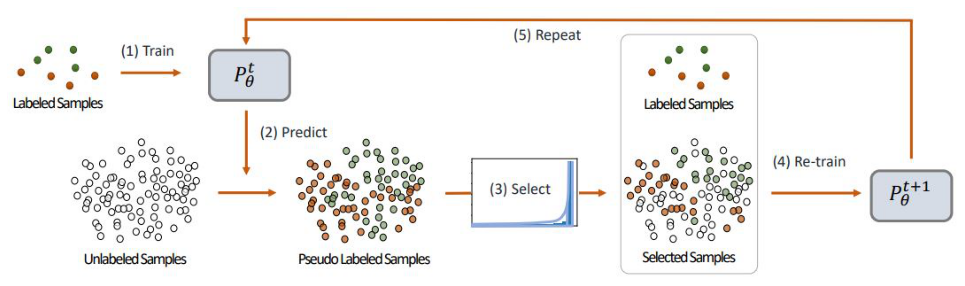

In [40]:
#@title
# please check that diagramm_paper.JPG is in your working directory
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

plt.figure(figsize = (20, 5))
img = mpimg.imread('diagram_paper.JPG')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Load data

In [41]:
#@title initialize datasets and dataloader for weak supervision

# transform compose for ResNet
mean_ImageNet, std_ImageNet, shape_ImageNet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
transform_ImageNet = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize(mean=mean_ImageNet, std=std_ImageNet),
                                        transforms.Resize(shape_ImageNet)])

# STEP 0 : indexes of initial trainset and unlabel set
idx_cifar = list(range(50000)) # 50000 samples in CIFAR trainset
idx_train = list(range(100)) # 100 first indexes for the train set
idx_unlabel = list(set(idx_cifar) - set(idx_train)) # indexes of unlabel data

# STEP 1 : load train with transform_train, load normal train
trainset_full_transform = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_ImageNet)
trainset_full_tensor = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_ImageNet)

# STEP 2 : initialize initial trainset, initialize unlabel set as datasets
traindataset = torch.utils.data.Subset(trainset_full_transform, idx_train)
unlabeldataset = torch.utils.data.Subset(trainset_full_tensor, idx_unlabel)

# STEP 3 : dataloader for initial traindataset, dataloader for unlabel dataset
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
unlabelloader = torch.utils.data.DataLoader(unlabeldataset, batch_size=batch_size, shuffle=False)

## Step 4 : test 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ImageNet)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

print(f'Train with {len(traindataset)} samples ! ')
print(f'Unlabel set with {len(unlabeldataset)} samples ! ')
print(f'Test with {len(testset)} samples ! ')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train with 100 samples ! 
Unlabel set with 49900 samples ! 
Test with 10000 samples ! 


In [42]:
#@title utils function

# train, test, get_indices_to_add, get_new_loaders

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss_return, train_acc_return = train_loss/(batch_idx+1), 100.*correct/total
    print(f'> TRAIN SET : Loss: {train_loss_return:.3f} | Acc: {train_acc_return:.2f}% !')
    return train_loss_return, train_acc_return

# Test
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        test_loss_return, test_acc_return = test_loss/(batch_idx+1), 100.*correct/total
        print(f'> TEST SET : Loss: {test_loss_return:.3f} | Acc: {test_acc_return}% !')
    
    return test_loss_return, test_acc_return

def get_indices_to_add(unlabelloader):
  '''
  from unlabel dataset loader
  returns 
    index_to_add : indices of samples from unlabel set to add to the train set
    new_train_index : indices of samples of updated train set
    new_classes_to_add : pseudo labels of samples to add to the train set
  '''
  all_outputs = [] # list that stock prediction

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(unlabelloader):
      # compute predictions of the network and add to the list
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      all_outputs.append(outputs.detach().cpu())

  # concatenate all outputs as tensor
  all_outputs = torch.cat(all_outputs)

  # apply softmax to get values between 0 and 1 for each sample
  softmax = nn.Softmax(dim=1)

  # apply max to softmax to get best prediction for each sample
  max_softmax, max_classes = torch.max(softmax(all_outputs), dim=1)
  index_to_add = torch.where(max_softmax > 0.85)[0].detach().cpu().numpy() 

  # get index of samples to add to train for the next iteration
  new_train_index = np.concatenate((np.arange(100), index_to_add + 100))

  # extract classes of samples to add to the train set
  max_classes = max_classes.detach().cpu().numpy()
  new_classes_to_add = max_classes[index_to_add]

  return index_to_add.tolist(), new_train_index.tolist(), new_classes_to_add

def get_new_datasets(index_to_add, new_train_index, new_classes_to_add,  traindataset):
  '''
  from index to add to the train set, updated index of the train set, pseudo labels and traindataset
  returns new train/unlabel dataset
  inputs:
    new_train_index : indexes of samples of trainset
    new_classes_to_add : predicted classes of samples to move from unlabel to train set
    traindataset : current train dataset object
  returns:
    traindataset : updated training dataset
    unlabeldataset : updated unlabel dataset
  '''
  # add classes to add to the trainset
  label_train_transform = trainset_full_transform.targets.copy() # copy original traindataset index
  label_train_transform = np.array(label_train_transform)
  label_train_transform[index_to_add] = new_classes_to_add # update by adding new labels
  label_train_transform = label_train_transform.tolist()
  # update targets of trainset
  trainset_full_transform.targets = label_train_transform # update labels of traindataset

  # remove indexes of sample to remove to the unlabel set
  idx_unlabel = list(set(idx_cifar) - set(new_train_index)) # indexes of unlabel data

  # RELOAD TRAIN dataset
  traindataset = torch.utils.data.Subset(trainset_full_transform, new_train_index)
  # RELOAD UNLABEL dataset
  unlabeldataset = torch.utils.data.Subset(trainset_full_tensor, idx_unlabel)

  return traindataset, unlabeldataset

In [43]:
#@title iterate for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_losses, test_losses, train_acc, test_acc = [], [], [], []
stop_condition = True
max_iterations, count_iterations = 10, 0
while(stop_condition and (count_iterations < max_iterations)):

  count_iterations += 1
  print(f'\n----- Iteration #{count_iterations} with {len(traindataset)} samples in trainset -----')

  # Initialize model for new iteration
  net = ResNetTransfert(version=34)
  net = net.to(device)

  # criterion, optimizer
  lr = 0.01
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.7)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  for epoch in range(0, 10):
      # Step 1 : train on trainset
      train_loss_epoch, train_acc_epoch = train(epoch)
      train_losses.append(train_loss_epoch)
      train_acc.append(train_acc_epoch)

      # Step 2 : test on testset
      if(epoch==9):
        test_loss_epoch, test_acc_epoch = test(epoch)
        test_losses.append(test_loss_epoch)
        test_acc.append(test_acc_epoch)

      scheduler.step()

  # Step 3 : get best prediction from unlabel set
  index_to_add, new_train_index, new_classes_to_add = get_indices_to_add(unlabelloader)

  # Step 4 : get new train/unlabel loader for next iteration
  traindataset, unlabeldataset = get_new_datasets(index_to_add, new_train_index, new_classes_to_add,  traindataset)
  trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
  unlabelloader = torch.utils.data.DataLoader(unlabeldataset, batch_size=batch_size, shuffle=False)

  # Step 5 : check stop condition
  stop_condition = len(traindataset) < 25000 # repeat until size of train is greater than threhshold

----- Iteration #1 with 100 samples in trainset -----


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 0
> TRAIN SET : Loss: 2.295 | Acc: 20.00% !

Epoch: 1
> TRAIN SET : Loss: 2.060 | Acc: 31.00% !

Epoch: 2
> TRAIN SET : Loss: 1.943 | Acc: 34.00% !

Epoch: 3
> TRAIN SET : Loss: 1.809 | Acc: 44.00% !

Epoch: 4
> TRAIN SET : Loss: 1.603 | Acc: 47.00% !

Epoch: 5
> TRAIN SET : Loss: 1.339 | Acc: 69.00% !

Epoch: 6
> TRAIN SET : Loss: 1.206 | Acc: 71.00% !

Epoch: 7
> TRAIN SET : Loss: 1.048 | Acc: 77.00% !

Epoch: 8
> TRAIN SET : Loss: 0.812 | Acc: 81.00% !

Epoch: 9
> TRAIN SET : Loss: 0.652 | Acc: 94.00% !
> TEST SET : Loss: 1.524 | Acc: 46.73% !
----- Iteration #2 with 1581 samples in trainset -----

Epoch: 0
> TRAIN SET : Loss: 0.891 | Acc: 74.95% !

Epoch: 1
> TRAIN SET : Loss: 0.496 | Acc: 86.21% !

Epoch: 2
> TRAIN SET : Loss: 0.450 | Acc: 87.86% !

Epoch: 3
> TRAIN SET : Loss: 0.405 | Acc: 88.17% !

Epoch: 4
> TRAIN SET : Loss: 0.376 | Acc: 88.74% !

Epoch: 5
> TRAIN SET : Loss: 0.315 | Acc: 91.02% !

Epoch: 6
> TRAIN SET : Loss: 0.321 | Acc: 90.39% !

Epoch: 7
> TRAIN SE

KeyboardInterrupt: ignored

<u>**Observations for Weak supervision**</u> : It can be seen that the training time is significantly longer than the previous methods because the model is trained and tested at each iteration. Here the method is sensitive to the data added to the train set at each iteration. An early stopping is performed to obtain the best accuracy of 73.48% on the test set.

# END TP4 !

Thank you for reading !